In [6]:
import torch
import torch.nn as nn
import torch.nn.init as init  # 添加这行导入
from torchvision import models
from torch.nn import functional as F
from fvcore.nn import FlopCountAnalysis
from torchinfo import summary
class USAM(nn.Module):
    def __init__(self, kernel_size=3, padding=1, polish=True):
        super(USAM, self).__init__()
        kernel = torch.ones((kernel_size, kernel_size))
        kernel = kernel.unsqueeze(0).unsqueeze(0)
        self.weight = nn.Parameter(data=kernel, requires_grad=False)
        
        kernel2 = torch.ones((1, 1)) * (kernel_size * kernel_size)
        kernel2 = kernel2.unsqueeze(0).unsqueeze(0)
        self.weight2 = nn.Parameter(data=kernel2, requires_grad=False)

        self.polish = polish
        self.pad = padding
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        fmap = x.sum(1, keepdim=True)      
        x1 = F.conv2d(fmap, self.weight, padding=self.pad)
        x2 = F.conv2d(fmap, self.weight2, padding=0) 
        
        att = x2 - x1
        att = self.bn(att)
        att = self.relu(att)

        if self.polish:
            mask = torch.ones_like(att)
            mask[:, :, :, 0] = 0
            mask[:, :, :, -1] = 0
            mask[:, :, 0, :] = 0
            mask[:, :, -1, :] = 0
            att = att * mask

        output = x + att * x
        return output

class GeM(nn.Module):
    def __init__(self, dim=2048, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(dim)*p, requires_grad=True)
        self.eps = eps
        self.dim = dim
        
    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        x = torch.transpose(x, 1, -1)
        x = x.clamp(min=eps).pow(p)
        x = torch.transpose(x, 1, -1)
        x = F.avg_pool2d(x, (x.size(-2), x.size(-1)))
        x = x.view(x.size(0), x.size(1))
        x = x.pow(1./p)
        return x

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ',' + 'dim='+str(self.dim)+')'

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f=False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate > 0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
        
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return x, f
        else:
            x = self.classifier(x)
            return x

class Concat(nn.Module):
    def forward(self, x):
        if isinstance(x, tuple):
            return torch.cat(x, dim=1)
        return x

class ft_net(nn.Module):
    def __init__(self, class_num, sp, droprate=0.5, stride=2, init_model=None, pool='avg'):
        super(ft_net, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        
        if stride == 1:
            model_ft.layer4[0].downsample[0].stride = (1, 1)
            model_ft.layer4[0].conv2.stride = (1, 1)

        self.pool = pool
        if pool == 'avg+max':
            model_ft.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
            model_ft.maxpool2 = nn.AdaptiveMaxPool2d((1, 1))
        elif pool == 'avg':
            model_ft.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        elif pool == 'max':
            model_ft.maxpool2 = nn.AdaptiveMaxPool2d((1, 1))
        elif pool == 'gem':
            model_ft.gem2 = GeM(dim=2048)  

        if init_model is not None:
            model_ft = init_model.model
            self.pool = init_model.pool

        self.usam_1 = USAM()
        self.usam_2 = USAM()
        self.classifier = ClassBlock(2048, class_num, droprate)

        self.total_module_list = [
            model_ft.conv1,
            model_ft.bn1,
            model_ft.relu,
            self.usam_1,
            model_ft.maxpool,
            model_ft.layer1,
            self.usam_2,
            model_ft.layer2,
            model_ft.layer3,
            model_ft.layer4
        ]

        # 调整pooling层的添加逻辑，确保self.classifier被正确添加
        if pool == 'avg+max':
            self.total_module_list.extend([
                model_ft.avgpool2,
                model_ft.maxpool2,
                Concat(),
                Flatten(),
                self.classifier  # 添加分类器
            ])
        elif pool == 'avg':
            self.total_module_list.extend([
                model_ft.avgpool2,
                Flatten(),
                self.classifier  # 添加分类器
            ])
        elif pool == 'max':
            self.total_module_list.extend([
                model_ft.maxpool2,
                Flatten(),
                self.classifier  # 添加分类器
            ])
        elif pool == 'gem':
            self.total_module_list.extend([
                model_ft.gem2,
                Flatten(),
                self.classifier  # 添加分类器
            ])
        self.f = nn.Sequential(*self.total_module_list[0:sp])
        self.g = nn.Sequential(*self.total_module_list[sp:])

    def forward(self, x):
        x = self.f(x)
        x_attack = x.clone().detach()
        x = self.g(x)
        # x = self.classifier(x)
        return x, x_attack

def analyze_model():
    # 确保所有计算在CPU上进行
    device = torch.device('cpu')
    
    # 创建模型实例
    class_num = 1000
    sp = 6  # 分割点（不影响前10层分析）
    
    # 创建完整模型并放在CPU上
    ft_model = ft_net(class_num, sp).to(device)
    ft_model.eval()
    
    # 设置输入尺寸 (batch_size, channels, height, width)
    input_size = (1, 3, 384, 384)
    input_tensor = torch.randn(input_size).to(device)
    
    # 定义表格中指定层的名称（与索引0-9对应）
    module_names = [
        "model_ft.conv1",   # 索引0
        "model_ft.bn1",     # 索引1
        "model_ft.relu",    # 索引2
        "self.usam_1",      # 索引3
        "model_ft.maxpool", # 索引4
        "model_ft.layer1",  # 索引5
        "self.usam_2",      # 索引6
        "model_ft.layer2",  # 索引7
        "model_ft.layer3",  # 索引8
        "model_ft.layer4"   # 索引9
        "model_ft.rest"     # 索引10
    ]
    
    # 获取需要分析的前10层
    layers_to_analyze = ft_model.total_module_list
    
    print("=" * 80)
    print("指定层的计算量、输出特征形状及总推理计算量分析")
    print("=" * 80)
    
    results = []
    current_x = input_tensor.clone()  # 初始输入张量
    total_flops = 0  # 总推理计算量（前10层）
    
    # 用于累积rest层的计算量和参数
    rest_flops = 0
    rest_params = 0
    rest_input_shape = None
    rest_output_shape = None
    
    for i, layer in enumerate(layers_to_analyze):
        # 记录当前层输入形状
        input_shape = current_x.shape
        
        # 计算当前层的FLOPs
        flop_analyzer = FlopCountAnalysis(layer, current_x)
        layer_flops = flop_analyzer.total()
        
        # 计算当前层的参数数量
        layer_params = sum(p.numel() for p in layer.parameters())
        
        # 前向传播，获取输出形状
        with torch.no_grad():
            # 特殊处理Concat层，因为它需要元组输入
            if isinstance(layer, Concat):
                avg_output = ft_model.total_module_list[i-2](current_x)  # avgpool
                max_output = ft_model.total_module_list[i-1](current_x)  # maxpool
                current_x = layer((avg_output, max_output))
            else:
                current_x = layer(current_x)
        output_shape = current_x.shape
        
        # 如果是layer4之后的层，累积到rest层
        if i >= 9:  # layer4是索引9
            if rest_input_shape is None:
                rest_input_shape = input_shape
            rest_flops += layer_flops
            rest_params += layer_params
            rest_output_shape = output_shape
        else:
            # 保存layer4之前的层信息
            results.append({
                'index': i,
                'module_name': module_names[i],
                'input_shape': input_shape,
                'output_shape': output_shape,
                'flops': layer_flops,
                'params': layer_params
            })
        
        # 累加总FLOPs
        total_flops += layer_flops
    
    # 添加合并后的rest层信息
    results.append({
        'index': 10,
        'module_name': module_names[10],
        'input_shape': rest_input_shape,
        'output_shape': rest_output_shape,
        'flops': rest_flops,
        'params': rest_params
    })
    
    # 输出每层详细信息
    for res in results:
        print(f"索引：{res['index']}")
        print(f"模块名称：{res['module_name']}")
        print(f"输入形状：{res['input_shape']}")
        print(f"输出特征形状：{res['output_shape']}")
        print(f"FLOPs：{res['flops'] / 1e9:.4f} GFLOPs")  # 转换为GFLOPs
        print(f"参数数量：{res['params'] / 1e6:.4f} M")    # 转换为M
        print("-" * 50)
    
    # 输出总推理计算量
    print(f"整个推理过程的总FLOPs：{total_flops / 1e9:.4f} GFLOPs")

# 执行分析
analyze_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::sub encountered 1 time(s)
Unsupported operator aten::ones_like encountered 1 time(s)
Unsupported operator aten::fill_ encountered 4 time(s)
Unsupported operator aten::mul encountered 2 time(s)
Unsupported operator aten::add encountered 1 time(s)
Unsupported operator aten::max_pool2d encountered 1

指定层的计算量、输出特征形状及总推理计算量分析


Unsupported operator aten::add_ encountered 6 time(s)
Unsupported operator aten::add_ encountered 3 time(s)


IndexError: list index out of range

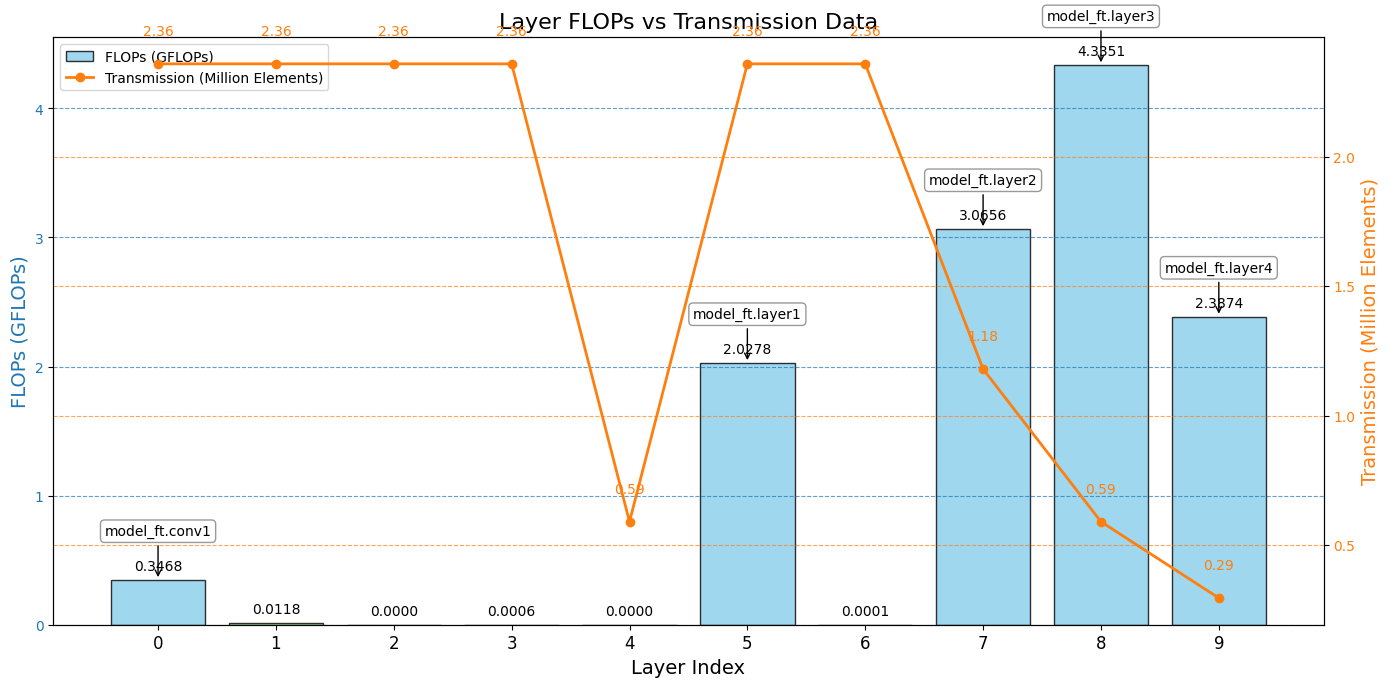

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 直接使用环境已有字体（避免中文依赖）
plt.rcParams["font.family"] = ['DejaVu Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 修复负号显示

# 原始数据（补充输出特征形状 & 传输数据量计算）
layer_data = [
    {"index": 0, "module_name": "model_ft.conv1", "flops": 0.3468, "output_shape": (1, 64, 192, 192)},
    {"index": 1, "module_name": "model_ft.bn1", "flops": 0.0118, "output_shape": (1, 64, 192, 192)},
    {"index": 2, "module_name": "model_ft.relu", "flops": 0.0000, "output_shape": (1, 64, 192, 192)},
    {"index": 3, "module_name": "self.usam_1", "flops": 0.0006, "output_shape": (1, 64, 192, 192)},
    {"index": 4, "module_name": "model_ft.maxpool", "flops": 0.0000, "output_shape": (1, 64, 96, 96)},
    {"index": 5, "module_name": "model_ft.layer1", "flops": 2.0278, "output_shape": (1, 256, 96, 96)},
    {"index": 6, "module_name": "self.usam_2", "flops": 0.0001, "output_shape": (1, 256, 96, 96)},
    {"index": 7, "module_name": "model_ft.layer2", "flops": 3.0656, "output_shape": (1, 512, 48, 48)},
    {"index": 8, "module_name": "model_ft.layer3", "flops": 4.3351, "output_shape": (1, 1024, 24, 24)},
    {"index": 9, "module_name": "model_ft.layer4", "flops": 2.3874, "output_shape": (1, 2048, 12, 12)},
]

# 计算传输数据量（元素数量 → 转换为百万元素）
for data in layer_data:
    elements = np.prod(data["output_shape"])  
    data["transmission_million"] = elements / 1e6  # 单位：百万元素


def plot_flops_and_transmission(layer_data):
    """
    双纵轴可视化：左轴=计算量(GFLOPs)，右轴=传输数据量(百万元素)
    """
    indices = [d["index"] for d in layer_data]
    flops = [d["flops"] for d in layer_data]
    transmission = [d["transmission_million"] for d in layer_data]
    names = [d["module_name"] for d in layer_data]

    # 创建画布 + 主轴（计算量）
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # 1. 绘制计算量柱状图（返回 BarContainer，设置整体 label）
    colors = ['skyblue' if i in [0, 5, 7, 8, 9] else 'lightgreen' for i in indices]
    bars_flops = ax1.bar(
        indices, flops, 
        color=colors, edgecolor='black', alpha=0.8, 
        label='FLOPs (GFLOPs)'  # 柱状图整体 label
    )

    # 配置主轴
    ax1.set_title('Layer FLOPs vs Transmission Data', fontsize=16)
    ax1.set_xlabel('Layer Index', fontsize=14)
    ax1.set_ylabel('FLOPs (GFLOPs)', fontsize=14, color='tab:blue')
    ax1.set_xticks(indices)
    ax1.set_xticklabels(indices, fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(axis='y', linestyle='--', alpha=0.7, color='tab:blue')

    # 2. 创建副轴（传输数据量）
    ax2 = ax1.twinx()
    # 绘制传输量折线图（返回 Line2D 列表，设置整体 label）
    lines_trans = ax2.plot(
        indices, transmission, marker='o', color='tab:orange', 
        linewidth=2, label='Transmission (Million Elements)'  # 折线图整体 label
    )

    # 配置副轴
    ax2.set_ylabel('Transmission (Million Elements)', fontsize=14, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.grid(axis='y', linestyle='--', alpha=0.7, color='tab:orange')

    # 3. 标注数值（计算量+传输量）
    # 标注计算量（柱状图）
    for bar, val in zip(bars_flops, flops):
        ax1.text(
            bar.get_x() + bar.get_width()/2, val + 0.05, 
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, color='black'
        )
    
    # 标注传输量（折线图）
    for i, val in enumerate(transmission):
        ax2.text(
            indices[i], val + 0.1, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, color='tab:orange'
        )

    # 4. 合并图例（关键修复：显式获取两个轴的图例）
    # 获取柱状图的图例句柄和标签
    handles_flops, labels_flops = ax1.get_legend_handles_labels()
    # 获取折线图的图例句柄和标签（取第一条线，因为 plot 返回列表）
    handles_trans, labels_trans = ax2.get_legend_handles_labels()

    # 合并句柄和标签
    handles = handles_flops + handles_trans
    labels = labels_flops + labels_trans

    # 创建图例（仅显示两个条目：柱状图 + 折线图）
    ax1.legend(handles, labels, loc='upper left')

    # 仅为计算量大的层添加名称注释
    for i, (idx, name, val) in enumerate(zip(indices, names, flops)):
        if val > 0.1:
            ax1.annotate(
                name, xy=(idx, val), xytext=(0, 30),
                textcoords="offset points", ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0")
            )

    # 调整布局
    plt.tight_layout()
    plt.show()


# 执行绘图
plot_flops_and_transmission(layer_data)

In [3]:
import matplotlib.font_manager as fm

# 列出所有可用字体名称
font_list = [f.name for f in fm.fontManager.ttflist]
print("环境内可用字体：", font_list)

# 筛选中文字体（含中文名称或拼音）
chinese_fonts = [f for f in font_list if any(c in f for c in ["Sim", "Sun", "Hei", "WenQuan", "Song"])]
print("\n可能支持中文的字体：", chinese_fonts)

环境内可用字体： ['DejaVu Sans Mono', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'cmb10', 'DejaVu Sans Display', 'cmex10', 'DejaVu Serif', 'STIXNonUnicode', 'cmss10', 'STIXSizeFourSym', 'DejaVu Serif', 'STIXGeneral', 'DejaVu Sans', 'STIXSizeThreeSym', 'STIXGeneral', 'STIXSizeFourSym', 'DejaVu Sans', 'cmsy10', 'DejaVu Sans', 'STIXSizeFiveSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeOneSym', 'DejaVu Serif', 'DejaVu Serif Display', 'STIXNonUnicode', 'STIXNonUnicode', 'cmr10', 'STIXGeneral', 'STIXSizeTwoSym', 'STIXGeneral', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'cmtt10', 'STIXNonUnicode', 'cmmi10', 'DejaVu Sans Mono', 'Noto Serif CJK JP', 'Noto Serif CJK JP', 'Noto Sans CJK JP', 'Noto Sans CJK JP']

可能支持中文的字体： []
